## Trabajo Fin de Máster <br/> Diseño de una arquitectura multimodal para descripción textual de pares imagen-audio

## Script 4. Entrenamiento del modelo CLIP con base de datos propia

En este notebook, empleamos la base de datos de imágenes que obtuvimos en el Script 3 para realizar fine-tuning sobre el modelo preentrenado CLIP (Contrastive Language-Image Pre-Training), creado por OpenAI.

### Paso 1. Importación de paquetes

In [1]:
import os
os.chdir("..")
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts'

In [2]:
import torch
import torch.nn as nn

import clip
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, Subset, SubsetRandomSampler, DataLoader

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from tfm_lib.EarlyStopping import EarlyStopping
from tfm_lib.modelos import CLIP_adapted
from tfm_lib.datasets import ImageDataset

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import random
import numpy as np
import pandas as pd

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

In [4]:
torch.autograd.set_detect_anomaly(True)

### Paso 2. Configuración e inicialización de wandb

In [5]:
import wandb

In [6]:
!wandb login 1b8abaacf33b7b5812267384768c22a1eef3c11e

wandb: Appending key for api.wandb.ai to your netrc file: /home/azureuser/.netrc


In [7]:
folder_path = './../Final_Database/image'
num_epochs = 20
BATCH_SIZE = 16
data_augmentation = True
da = "_DA" if data_augmentation else ""
lr = 1e-4
output_dim = 10
selected_model = 'RN50'

model_parameters_file = f"./modelos/clip/CLIP_{selected_model.replace('/','')}_{output_dim}pers_lr{f'{lr:.0e}'}_bs{BATCH_SIZE}_{num_epochs}ep{da}.pt"
print(model_parameters_file)

./modelos/clip/CLIP_RN50_10pers_lr1e-04_bs16_20ep_DA.pt


In [8]:
# WandB – Initialize a new run
run_name = model_parameters_file.split("/")[-1].replace('.pt', '')
wandb.init(entity="josealbertoap", project='TFM', name = run_name, tags=["image"])

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = BATCH_SIZE          # input batch size for training (default: 64)
config.test_batch_size = BATCH_SIZE    # input batch size for testing (default: 1000)
config.epochs = num_epochs             # number of epochs to train (default: 10)
config.lr = lr              # learning rate (default: 0.01)
config.momentum = 0          # SGD momentum (default: 0.5)
config.no_cuda = True         # disables CUDA training
config.seed = 0               # random seed (default: 42)
config.log_interval = 1     # how many batches to wait before logging training status
config.num_classes = output_dim

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: josealbertoap. Use `wandb login --relogin` to force relogin


### Definición de la función de pérdida

In [9]:
# Función de pérdida
def loss_fn(logits, labels):
    """
    logits: Las salidas del modelo (predicciones) para cada clase.
    labels: Las etiquetas verdaderas (números enteros) para cada ejemplo.
    """
    criterion = nn.CrossEntropyLoss()  # Función de pérdida de entropía cruzada
    return criterion(logits, labels)

# Ejemplo de cómo usar la función de pérdida
logits = torch.tensor([[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.3, 0.2, 0.5]])
labels = torch.tensor([0, 1, 2])

loss = loss_fn(logits, labels)
print("Pérdida:", loss.item())

Pérdida: 0.7991690635681152


### Entrenamiento del modelo

In [10]:
from torchvision.transforms import Resize, Compose, ColorJitter, RandomHorizontalFlip, \
                                   RandomResizedCrop, RandomRotation, Normalize, ToTensor

def train_test_dataloaders(database_df, model, num_classes, data_augmentation=False, BATCH_SIZE=32, test_split=0.2):

    dataset = ImageDataset(database_df, num_classes, image_transform = model.preprocess)

    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_sampler = SubsetRandomSampler(train_idx)

    # test_subset = Subset(dataset, test_idx) # En caso de que quisiéramos un Dataset y no un Dataloader
    test_sampler = SubsetRandomSampler(test_idx)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=512, sampler=test_sampler)

    # En caso de tener data augmentation, cambiamos el dataset para el Dataloader de train
    if data_augmentation:

      augmentation = Compose([
            RandomHorizontalFlip(p=0.3),
            RandomRotation(degrees=(0, 45), fill=0),
            RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.8, 1.2)),
            ToTensor(),
            Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
        ])

      dataset = ImageDataset(database_df, num_classes, image_transform = augmentation)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    return train_loader, test_loader, dataset.labelencoder.classes_

In [11]:
# Descargamos el modelo pre-entrenado y procesador de CLIP
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CLIP_adapted(selected_model, device, output_dim)
for param in model.parameters():
    param.requires_grad = True

train_loader, test_loader, classes = train_test_dataloaders(pd.read_csv(f'{folder_path}/imagesDB_train.csv'),
                                                            model, output_dim, data_augmentation, BATCH_SIZE, 0.2)

In [12]:
# Inicializa el optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3)

train_loss = {}
test_loss = {}
train_acc = {}
test_acc = {}

# Creamos la lista de descripciones para evaluar el modelo
print(f"People:{classes}\n")
eval_descriptions = torch.cat([clip.tokenize(f"a photo of {c}") for c in classes])

early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.01, path=model_parameters_file)

wandb.watch(model, log="all")

for epoch in range(num_epochs):

    # Entrena el modelo
    model.train()
    epoch_loss = 0.0
    total_correct = 0
    total_samples = 0

    train_steps = tqdm(train_loader, unit="batch")

    for images, labels in train_steps:

        train_steps.set_description(f"Epoch [{epoch+1}/{num_epochs}]. Training")

        optimizer.zero_grad()
        texts = eval_descriptions.to(device)
        images = images.to(device)
        labels = labels.to(device)

        output = model(images, texts)

        # Cálculo de la accuracy
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()

        total_samples += labels.size(0)
        total_correct += correct

        # Cálculo de la función de pérdida y actualización del modelo
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_steps.set_postfix(mean_loss=epoch_loss/total_samples, mean_accuracy = total_correct / total_samples)

    train_loss[epoch+1] = epoch_loss / len(train_loader)
    train_acc[epoch+1] = total_correct / total_samples

    # Evaluación en el conjunto de prueba
    model.eval()  # Cambiamos al modo de evaluación
    epoch_loss = 0.0
    total_correct = 0
    total_samples = 0

    test_steps = tqdm(test_loader, unit="batch")

    with torch.no_grad():
        for images, labels in test_steps:  # Itera sobre los datos de prueba

            test_steps.set_description(f"Epoch [{epoch+1}/{num_epochs}]. Evaluation")

            texts = eval_descriptions.to(device)
            images = images.to(device)
            labels = labels.to(device)

            output = model(images, texts)

            # Cálculo de la accuracy
            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            correct = (predictions == labels).sum().item()

            total_samples += labels.size(0)
            total_correct += correct

            # Cálculo de la función de pérdida y actualización del modelo
            loss = loss_fn(output, labels)
            epoch_loss += loss.item()

            test_steps.set_postfix(mean_loss=epoch_loss/total_samples, mean_accuracy = total_correct / total_samples)

        test_loss[epoch+1] = epoch_loss / len(test_loader)
        test_acc[epoch+1] = total_correct / total_samples

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'- Training. Loss = {train_loss[epoch+1]}; Accuracy = {train_acc[epoch+1]}.')
        print(f'- Evaluation. Loss = {test_loss[epoch+1]}; Accuracy = {test_acc[epoch+1]}.')

        wandb.log({
                    'Epoch': epoch+1,
                    'Training Loss': train_loss[epoch+1],
                    'Training Accuracy': train_acc[epoch+1],
                    'Evaluation Loss': test_loss[epoch+1],
                    'Evaluation Accuracy': test_acc[epoch+1],
                })

        # Llamar a early_stopping con la pérdida de validación actual y el modelo
        early_stopping(test_loss[epoch+1], model)
        print('')

        # Si se alcanza el criterio de early stopping, romper el bucle
        if early_stopping.early_stop:
            print("Early stopping")
            break

        # Reducir el learning rate en caso de que no esté mejorando la pérdida
        scheduler.step(test_loss[epoch+1])

print({'train_acc': train_acc, 'train_loss': train_loss, 'val_acc': test_acc, 'val_loss': test_loss})

wandb.save(model_parameters_file)

People:['Alba Azorin Zafrilla' 'Alfonso Girona Palao' 'Alfonso Vidal Lopez'
 'Ana Azorin Puche' 'Ana Puche Palao' 'Angela Espinosa Martinez'
 'Clara Hidalgo Lopez' 'Cristina Carpena Ortiz' 'David Azorin Soriano'
 'Jose Alberto Azorin Puche']

Epoch [1/20]:
- Training. Loss = 3.493299060142957; Accuracy = 0.20807833537331702.
- Evaluation. Loss = 3.6380984783172607; Accuracy = 0.11707317073170732.
Validation loss decreased (inf --> 3.638098).  Saving model ...

Epoch [2/20]:
- Training. Loss = 1.500705939072829; Accuracy = 0.5104039167686658.
- Evaluation. Loss = 3.838458299636841; Accuracy = 0.0975609756097561.
EarlyStopping counter: 1 out of 5

Epoch [3/20]:
- Training. Loss = 1.218209402492413; Accuracy = 0.609547123623011.
- Evaluation. Loss = 2.0798909664154053; Accuracy = 0.25853658536585367.
Validation loss decreased (3.638098 --> 2.079891).  Saving model ...

Epoch [4/20]:
- Training. Loss = 1.0744217978074; Accuracy = 0.6793145654834761.
- Evaluation. Loss = 3.2720110416412354;

Epoch [17/20]. Evaluation: 100%|██████████| 1/1 [00:46<00:00, 46.17s/batch, mean_accuracy=0.932, mean_loss=0.000978]


['/mnt/batch/tasks/shared/LS_root/mounts/clusters/tfm-cpu/code/Users/jose.puche/Scripts/wandb/run-20240725_102353-021l5v69/files/modelos/clip/CLIP_RN50_10pers_lr1e-04_bs16_20ep_DA.pt']

### Evaluación del modelo entrenado

In [13]:
test_dataset = ImageDataset(pd.read_csv(f'{folder_path}/imagesDB_test.csv'), 
                            output_dim, image_transform = model.preprocess)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1048, shuffle=True)

In [14]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():

    predictions = []
    label_list = []
    for data in test_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)
      texts = eval_descriptions.to(device)

      # Get predictions
      outputs = model(inputs, texts)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

      predictions.extend(prediction)
      label_list.extend(data[1])

  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

  return predictions, label_list

# Run inference on trained model with the validation set
model.load_state_dict(torch.load(model_parameters_file, map_location=torch.device('cpu')))
result = inference(model, test_dl)

Accuracy: 0.97, Total items: 258


{'Test accuracy': 0.9651162790697675, 'Test precision': 0.9682310719640179, 'Test recall': 0.9681697612732096, 'F1-score': 0.9654592766958376}


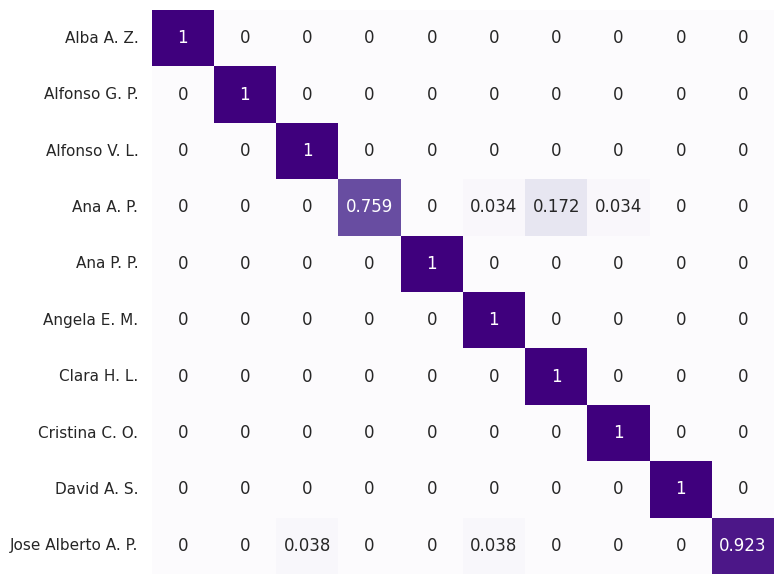

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import re

def extraer_iniciales(name):
    name_words = name.split(' ')
    r = re.compile("^[A-Z][A-z]*")
    valid_words = list(filter(r.match, name_words))
    if len(valid_words) <=3:
        name = valid_words[0]
        valid_words.remove(valid_words[0])
    else:
        name = f'{valid_words[0]} {valid_words[1]}'
        valid_words.remove(valid_words[0])
        valid_words.remove(valid_words[1])
    surname = re.sub('(?<=[A-Z])[A-z]+', '.', ' '.join(valid_words))
    return f'{name} {surname}'

def font_scale(num_classes):
    if num_classes <= 10:
        return 1.0
    elif num_classes <= 20:
        return 0.75
    elif num_classes <= 30:
        return 0.65
    else:
        return 0.45

def plot_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    people = list(map(extraer_iniciales, test_dataset.labelencoder.classes_))

    df_cm = pd.DataFrame((cf_matrix / np.sum(cf_matrix, axis=1)[:, None]).round(3), index=people, columns=people)
    
    plt.figure(figsize=(8, 6))  
    sn.set(font_scale = font_scale(df_cm.shape[0]))  
    heatmap = sn.heatmap(df_cm, annot=True, cbar=False, cmap='Purples', fmt='g', xticklabels=False)

    # Ajusta la rotación y alineación de los ticks de los ejes
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right')

    plt.tight_layout()  # Asegura que todo se ajuste bien en la figura
    plt.savefig(model_parameters_file.replace('/modelos/', '/results/').replace('.pt', '.png'))

    return plt.gcf()

def get_metrics(result):
    accuracy = accuracy_score(result[1], result[0])
    precision = precision_score(result[1], result[0], average='macro')
    recall = recall_score(result[1], result[0], average='macro')
    f1 = f1_score(result[1], result[0], average='macro')

    metrics = {
        'Test accuracy': accuracy,
        'Test precision': precision,
        'Test recall': recall,
        'F1-score': f1
    }

    print(metrics)

    metrics['Confusion Matrix'] = wandb.Image(plot_confusion_matrix(result[1],result[0]))
    metrics['Test metrics'] = wandb.Table(columns=["Metric name", "Value"], 
                                          data=[["Test accuracy", accuracy], ["Test precision", precision],
                                                ["Test recall", recall], ["Test F1-Score", f1]])

    return metrics

metrics = get_metrics(result)
wandb.log(metrics)

In [16]:
image_results = []

with torch.no_grad():

    for i in range(4):

        read_image = Image.open(f'./../Test_images/IMG_000{i}.jpg')
        image = model.preprocess(read_image).unsqueeze(0).to(device)

        output = model(image, eval_descriptions)
        probs = torch.round(output.softmax(dim=-1), decimals=4)
        pred_prob = torch.max(probs).item()
        pred_person = classes[torch.argmax(probs)]
        my_prob = probs.squeeze()[list(classes).index('Jose Alberto Azorin Puche')].item()

        image_results.append([f'Imagen {i+1}', pred_person, pred_prob, my_prob])
print(image_results)
wandb.log({"Test images results": wandb.Table(columns=["Imagen", "Persona", "Probabilidad", "Prob (Joseal)"], data=image_results)})        


[['Imagen 1', 'Cristina Carpena Ortiz', 0.4433000087738037, 0.0003000000142492354], ['Imagen 2', 'Cristina Carpena Ortiz', 0.391400009393692, 0.017000000923871994], ['Imagen 3', 'Alba Azorin Zafrilla', 0.5950000286102295, 0.0005000000237487257], ['Imagen 4', 'Clara Hidalgo Lopez', 0.9570000171661377, 0.000699999975040555]]


In [17]:
wandb.finish()

Epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
Evaluation Accuracy,▁▁▃▂▂▇▄▁▁▁█████▇█
Evaluation Loss,▄▄▂▃▅▁▂█▆▇▁▁▁▁▁▁▁
F1-score,▁
Test accuracy,▁
Test precision,▁
Test recall,▁
Training Accuracy,▁▄▅▆▆▇█▇█▇▆██████
Training Loss,█▄▃▃▂▁▁▁▁▂▃▁▁▁▁▁▁
Epoch,17
Evaluation Accuracy,0.93171
